In [2]:
from tensorflow.keras.callbacks import LearningRateScheduler, TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import warnings
import glob 
import os 
from eli5.sklearn import PermutationImportance
import eli5
from sklearn.metrics import make_scorer
import shap

# Make NumPy printouts easier to read.
np.set_printoptions(precision=5, suppress=True)
warnings.filterwarnings("ignore")

print(tf.__version__)

2.10.0


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
DATASET_CALOSC=pd.read_csv('../Dane/pogoda/Obrobione.csv')
DATASET_CALOSC=DATASET_CALOSC.drop(['przekaźnik pokojowy','praca_pieca','temperatura wewnętrzna na kominku','temperatura wewnętrzna nad kuchenką gazową'],axis=1)
DATASET_CALOSC

,temperatura zewnętrzna,wilgotność zewnętrzna,ciśnienie atmosferyczne,prędkość wiatru,kierunek wiatru,wilgotność wewnętrzna,temperatura wewnętrzna
0,0.000000,92.200000,972.80000,2.200000,80.00000,37.250000,22.1875
1,0.000000,92.000000,972.80000,3.200000,92.00000,37.250000,22.1875
2,0.000000,92.000000,972.80000,3.300000,92.00000,37.000000,22.1875
3,0.000000,91.900000,972.80000,3.300000,84.00000,37.000000,22.1875
4,0.000000,92.100000,972.80000,2.900000,98.00000,37.000000,22.2500
...,...,...,...,...,...,...,...
78093,14.674074,40.170370,999.50000,1.423077,214.00000,33.560127,21.8750
78094,14.774074,39.485185,999.50000,1.553846,303.07692,33.689873,21.8750
78095,14.725926,38.533333,999.42593,1.600000,185.69231,33.750000,21.8750
78096,14.625926,38.596296,999.40000,1.215385,163.76923,33.560127,21.8750


In [5]:
x = DATASET_CALOSC.iloc[:, :6]  
y = DATASET_CALOSC.iloc[:, 6]   

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(x)

In [6]:
def custom_scheduler(epoch, lr):
    if epoch < 4:
        return lr
    else:
        return lr * tf.math.exp(-0.1)


model = tf.keras.models.Sequential([
    normalizer,
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1,activation='linear') 
])

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=['mae'])

scheduler = LearningRateScheduler(custom_scheduler)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1)
callbacks = [scheduler, tensorboard]

EPOCHS = 50
BATCH_SIZE=32

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks)

Epoch 1/50
1953/1953 [==============================] - 8s 3ms/step - loss: 24.5468 - mae: 2.3887 - lr: 0.0010
Epoch 2/50
1953/1953 [==============================] - 9s 4ms/step - loss: 0.1635 - mae: 0.3092 - lr: 0.0010
Epoch 3/50
1953/1953 [==============================] - 9s 4ms/step - loss: 0.1338 - mae: 0.2792 - lr: 0.0010
Epoch 4/50
1953/1953 [==============================] - 9s 5ms/step - loss: 0.1252 - mae: 0.2712 - lr: 0.0010
Epoch 5/50
1953/1953 [==============================] - 7s 4ms/step - loss: 0.1146 - mae: 0.2588 - lr: 9.0484e-04
Epoch 6/50
1953/1953 [==============================] - 6s 3ms/step - loss: 0.1061 - mae: 0.2494 - lr: 8.1873e-04
Epoch 7/50
1953/1953 [==============================] - 4s 2ms/step - loss: 0.0988 - mae: 0.2398 - lr: 7.4082e-04
Epoch 8/50
1953/1953 [==============================] - 5s 2ms/step - loss: 0.0945 - mae: 0.2346 - lr: 6.7032e-04
Epoch 9/50
1953/1953 [==============================] - 5s 2ms/step - loss: 0.0906 - mae: 0.2291 - lr: 

In [8]:
model.evaluate(x_test, y_test)

489/489 [==============================] - 1s 2ms/step - loss: 0.0668 - mae: 0.1912


[0.06676942855119705, 0.1912257969379425]

# Permutation Feature Importance

In [9]:
def model_score(x, y):
    return mean_squared_error(y, model.predict(x))

In [10]:
scorer = make_scorer(model_score, greater_is_better=True)

perm = PermutationImportance(model, scoring=scorer, random_state=1).fit(x_test, y_test)


489/489 [==============================] - 0s 897us/step


In [11]:
eli5.show_weights(perm, feature_names = x_test.columns.tolist())

Weight,Feature
77.8250 ± 2.1215,wilgotność zewnętrzna
35.7242 ± 2.2829,wilgotność wewnętrzna
33.3414 ± 2.7911,temperatura zewnętrzna
28.7688 ± 1.7611,ciśnienie atmosferyczne
11.9062 ± 0.7106,kierunek wiatru
-0.6703 ± 0.5450,prędkość wiatru


## Mapa ciepła wag

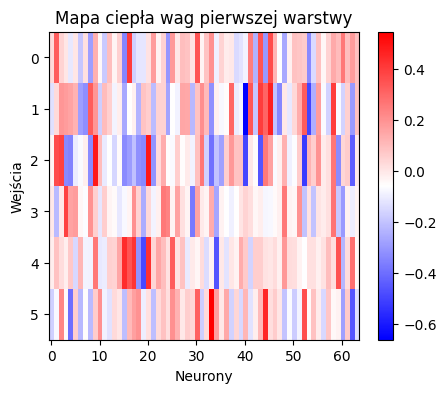

In [21]:
weights = model.layers[1].get_weights()[0]
# Używamy matplotlib do stworzenia mapy ciepła
plt.figure(figsize=(5, 4))
plt.imshow(weights, cmap='bwr', aspect='auto')  # Wybierz colormap według preferencji
plt.colorbar()  # Dodaje pasek z kolorami reprezentującymi wartości wag
plt.xlabel('Neurony')
plt.ylabel('Wejścia')
plt.show()

In [28]:
WEIGHTS=np.array([[0., 0., 0., 0., 0., 0.],])

for x in range(6):
    WEIGHTS[0,x]=weights[x,:].mean()

print(WEIGHTS)

WEIGHTS_min = WEIGHTS.min()
WEIGHTS_max = WEIGHTS.max()

WEIGHTS_normalized = (WEIGHTS - WEIGHTS_min) / (WEIGHTS_max - WEIGHTS_min)

print(WEIGHTS_normalized)

[[ 0.01435 -0.01152 -0.04798 -0.00506  0.0276   0.0007 ]]
[[0.82471 0.48235 0.      0.56787 1.      0.64402]]


## DUŻY MODEL

In [29]:
def custom_scheduler(epoch, lr):
    if epoch < 4:
        return lr
    else:
        return lr * tf.math.exp(-0.1)


model = tf.keras.models.Sequential([
    normalizer,
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1,activation='linear') 
])

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=['mae'])

scheduler = LearningRateScheduler(custom_scheduler)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1)
callbacks = [scheduler, tensorboard]

EPOCHS = 50
BATCH_SIZE=32

In [34]:
model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks)

Epoch 1/50
1953/1953 [==============================] - 7s 3ms/step - loss: 3.5129 - mae: 0.6745 - lr: 0.0010
Epoch 2/50
1953/1953 [==============================] - 7s 3ms/step - loss: 0.1993 - mae: 0.3486 - lr: 0.0010
Epoch 3/50
1953/1953 [==============================] - 7s 3ms/step - loss: 0.1820 - mae: 0.3344 - lr: 0.0010
Epoch 4/50
1953/1953 [==============================] - 7s 4ms/step - loss: 0.1609 - mae: 0.3132 - lr: 0.0010
Epoch 5/50
1953/1953 [==============================] - 7s 4ms/step - loss: 0.1368 - mae: 0.2884 - lr: 9.0484e-04
Epoch 6/50
1953/1953 [==============================] - 7s 3ms/step - loss: 0.1151 - mae: 0.2626 - lr: 8.1873e-04
Epoch 7/50
1953/1953 [==============================] - 7s 3ms/step - loss: 0.1073 - mae: 0.2531 - lr: 7.4082e-04
Epoch 8/50
1953/1953 [==============================] - 7s 3ms/step - loss: 0.0969 - mae: 0.2414 - lr: 6.7032e-04
Epoch 9/50
1953/1953 [==============================] - 7s 3ms/step - loss: 0.0880 - mae: 0.2287 - lr: 6

In [35]:
model.evaluate(x_test, y_test)

489/489 [==============================] - 1s 3ms/step - loss: 0.0237 - mae: 0.1088


[0.02368238940834999, 0.1088033989071846]

In [36]:
scorer = make_scorer(model_score, greater_is_better=True)

perm = PermutationImportance(model, scoring=scorer, random_state=1).fit(x_test, y_test)

489/489 [==============================] - 1s 1ms/step


In [37]:
eli5.show_weights(perm, feature_names = x_test.columns.tolist())

Weight,Feature
31.6574 ± 1.5953,wilgotność wewnętrzna
16.4930 ± 1.4987,ciśnienie atmosferyczne
1.7129 ± 0.7256,prędkość wiatru
-4.9887 ± 1.5786,wilgotność zewnętrzna
-5.4840 ± 1.8747,temperatura zewnętrzna
-6.5488 ± 0.6342,kierunek wiatru


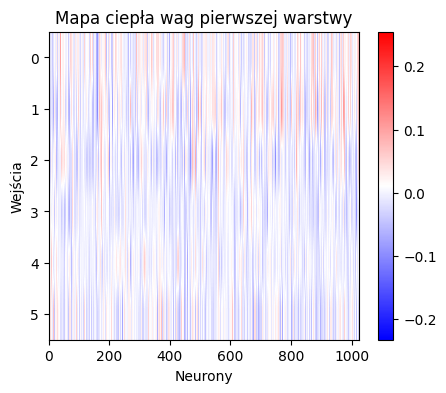

In [38]:
weights = model.layers[1].get_weights()[0]
# Używamy matplotlib do stworzenia mapy ciepła
plt.figure(figsize=(5, 4))
plt.imshow(weights, cmap='bwr', aspect='auto')  # Wybierz colormap według preferencji
plt.colorbar()  # Dodaje pasek z kolorami reprezentującymi wartości wag
plt.xlabel('Neurony')
plt.ylabel('Wejścia')
plt.show()

In [39]:
WEIGHTS=np.array([[0., 0., 0., 0., 0., 0.],])

for x in range(6):
    WEIGHTS[0,x]=weights[x,:].mean()

print(WEIGHTS)

WEIGHTS_min = WEIGHTS.min()
WEIGHTS_max = WEIGHTS.max()

WEIGHTS_normalized = (WEIGHTS - WEIGHTS_min) / (WEIGHTS_max - WEIGHTS_min)

print(WEIGHTS_normalized)

[[ 0.00896  0.00601 -0.00661 -0.00637 -0.00063 -0.00304]]
[[1.      0.81066 0.      0.01551 0.38409 0.22942]]


In [ ]:
# # Pobranie wag z pierwszej warstwy Dense
# weights = model.layers[1].get_weights()[0]

# colormaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis',
#              'Greys', 'Blues', 'BuGn', 'BuPu', 'GnBu', 'OrRd',
#              'PuBuGn', 'coolwarm', 'bwr', 'seismic', 'hot', 'cool',
#              'spring', 'summer', 'autumn', 'winter']

# # Tworzenie subplots
# plt.figure(figsize=(24, 24))  # Zwiększony rozmiar figury

# # Tworzenie kilku subplotów w siatce, w zależności od liczby colormapów
# rows = 5
# columns = 5

# for i, cmap in enumerate(colormaps, start=1):
#     plt.subplot(rows, columns, i)
#     plt.imshow(weights, cmap=cmap, aspect='auto')
#     plt.colorbar()
#     plt.title(f'Mapa ciepła wag pierwszej warstwy Dense - {cmap}')
#     plt.xlabel('Neurony')
#     plt.ylabel('Wejścia')

# plt.tight_layout()
# plt.show()